In [10]:
# Cell 1: Imports and Data Loading
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Check for GPU (Google Colab provides free T4 GPUs)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load datasets
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transform),
    batch_size=1000, shuffle=False)

Using device: cpu


In [11]:
# Cell 2: CNN Architecture
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        return self.fc2(x)

model = MNIST_CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [12]:
# Cell 3: Training and Evaluation
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}')

def test():
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    print(f'\nTest Set Accuracy: {100. * correct / len(test_loader.dataset):.2f}%')

# Run training for 2 epochs
for epoch in range(1, 3):
    train(epoch)
    test()

Train Epoch: 1 [0/60000] Loss: 2.313423
Train Epoch: 1 [12800/60000] Loss: 0.303033
Train Epoch: 1 [25600/60000] Loss: 0.097336
Train Epoch: 1 [38400/60000] Loss: 0.252503
Train Epoch: 1 [51200/60000] Loss: 0.067940

Test Set Accuracy: 98.44%
Train Epoch: 2 [0/60000] Loss: 0.064136
Train Epoch: 2 [12800/60000] Loss: 0.203175
Train Epoch: 2 [25600/60000] Loss: 0.022753
Train Epoch: 2 [38400/60000] Loss: 0.061282
Train Epoch: 2 [51200/60000] Loss: 0.027312

Test Set Accuracy: 98.70%


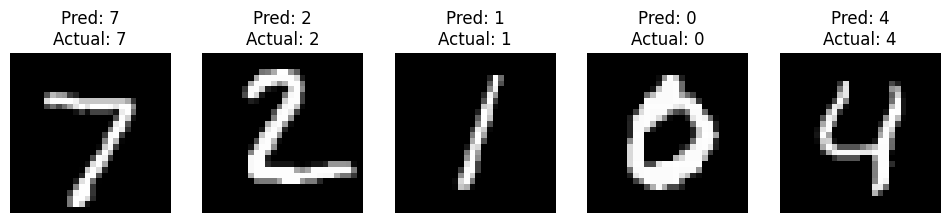

In [14]:
# Cell 4: Visualize Predictions
model.eval()
data, target = next(iter(test_loader))
data, target = data.to(device), target.to(device)
output = model(data)
preds = output.argmax(dim=1, keepdim=True)

plt.figure(figsize=(12, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(data[i].cpu().squeeze(), cmap='gray')
    plt.title(f"Pred: {preds[i].item()}\nActual: {target[i].item()}")
    plt.axis('off')
plt.show()